In [1]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import freq_bands_eeg, low_qual_chans

Change plot theme

In [2]:
sns.set_theme()

Define palettes

In [3]:
palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
palette_gr = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}
palette_gr_lighter = {'DRD2-WT':'#AEC2B3', 'DRD2-KO':'#C68083'}

Select the folder holding the epoch files we need and a plot output folder

In [3]:
epoch_folder = select_folder("Select the folder that holds sociability experiment's epoch files")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

2024-05-02 13:42:54.310 python[1981:61877] +[CATransaction synchronize] called within transaction
2024-05-02 13:43:06.566 python[1981:61877] +[CATransaction synchronize] called within transaction


## Analysis of one subject
Load the epochs of a test subject

In [4]:
subject_id = 78233
epochs = mne.read_epochs(os.path.join(epoch_folder, f"epochs_{subject_id}-epo.fif"), preload=True)
len(epochs)

34

Let's define the channels we wish to investigate

In [5]:
wanted_chans = [chan for chan in epochs.info['ch_names'] if chan not in ['EMG_L', 'EMG_R']]
wanted_chans

['OFC_R', 'OFC_L', 'CG', 'STR_R', 'S1_L', 'S1_R', 'V1_R']

In [6]:
print(f'There are {len(epochs)} epochs for subject {subject_id}')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "sniff"])} are sniffing epochs')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "groom"])} are grooming epochs')
print(f'{len(epochs[epochs.metadata["interaction_kind"] == "follow"])} are grooming epochs')

There are 34 epochs for subject 78233
23 are sniffing epochs
4 are grooming epochs
7 are grooming epochs


The Epoch Array metadata contains further information on how the epochs were created. Let's take a look.

In [7]:
epochs.metadata

subject_id genotype  interaction_n  interaction_part_n interaction_kind  \
0       78233  DRD2-WT              1                   1            sniff   
1       78233  DRD2-WT              1                   2            sniff   
2       78233  DRD2-WT              1                   3            sniff   
3       78233  DRD2-WT              2                   1           follow   
4       78233  DRD2-WT              3                   1            sniff   
5       78233  DRD2-WT              3                   2            sniff   
6       78233  DRD2-WT              4                   1            groom   
7       78233  DRD2-WT              5                   1            sniff   
8       78233  DRD2-WT              6                   1            sniff   
9       78233  DRD2-WT              6                   2            sniff   
10      78233  DRD2-WT              6                   3            sniff   
11      78233  DRD2-WT              7                   1           follow   
12      78233  DRD2-WT              8                   1           follow   
13      78233  DRD2-WT              8                   2           follow   
14      78233  DRD2-WT              8                   3           follow   
15      78233  DRD2-WT              8                   4           follow   
16      78233  DRD2-WT              9                   1           follow   
17      78233  DRD2-WT             10                   1            sniff   
18      78233  DRD2-WT             10                   2            sniff   
19      78233  DRD2-WT             10                   3            sniff   
20      78233  DRD2-WT             10                   4            sniff   
21      78233  DRD2-WT             11                   1            groom   
22      78233  DRD2-WT             12                   1            sniff   
23      78233  DRD2-WT             13                   1            sniff   
24      78233  DRD2-WT             14                   1            sniff   
25      78233  DRD2-WT             15                   1            sniff   
26      78233  DRD2-WT             15                   2            sniff   
27      78233  DRD2-WT             16                   1            groom   
28      78233  DRD2-WT             16                   2            groom   
29      78233  DRD2-WT             17                   1            sniff   
30      78233  DRD2-WT             18                   1            sniff   
31      78233  DRD2-WT             19                   1            sniff   
32      78233  DRD2-WT             20                   1            sniff   
33      78233  DRD2-WT             20                   2            sniff   

    total_interaction_duration  epoch_length  
0                        2.033           1.0  
1                        2.033           1.0  
2                        2.033           1.0  
3                        1.068           1.0  
4                        1.635           1.0  
5                        1.635           1.0  
6                        1.201           1.0  
7                        1.266           1.0  
8                        2.000           1.0  
9                        2.000           1.0  
10                       2.000           1.0  
11                       1.333           1.0  
12                       3.902           1.0  
13                       3.902           1.0  
14                       3.902           1.0  
15                       3.902           1.0  
16                       1.434           1.0  
17                       3.402           1.0  
18                       3.402           1.0  
19                       3.402           1.0  
20                       3.402           1.0  
21                       1.300           1.0  
22                       1.234           1.0  
23                       1.001           1.0  
24                       1.167           1.0  
25                       1.667           1.0  
26 

The metadata contains the interaction identifier. So all rows where *interaction_n* == 1 is data of one single event, with in this case is a sniff event.

The *interaction_part_n* tells you something about where along the total interaction duration that specific epoch is located.

Let's take the first interaction as an example. We can see, an interaction of 2.033 seconds yielded 3 epochs of 1 seconds.

### Define power -> decibel calculation function

In [8]:
def nanpow2db(y):
    """ Power to dB conversion, setting bad values to nans
        Arguments:
            y (float or array-like): power
        Returns:
            ydB (float or np array): inputs converted to dB with 0s and negatives resulting in nans
    """

    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB

### Plot the individual epoch powers

In [9]:
psds_sub_sniff, freqs = psd_array_multitaper(
    epochs[epochs.metadata.interaction_kind == 'sniff'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='WARNING'
)
psds_sub_groom, freqs = psd_array_multitaper(
    epochs[epochs.metadata.interaction_kind == 'groom'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='WARNING'
)
psds_sub_follow, freqs = psd_array_multitaper(
    epochs[epochs.metadata.interaction_kind == 'follow'].get_data(picks="STR_R"),
    fmin=0, fmax=100,
    sfreq=epochs.info['sfreq'],
    n_jobs=-1,
    verbose='WARNING'
)

In [10]:
psds_sub_sniff.shape

(23, 1, 101)

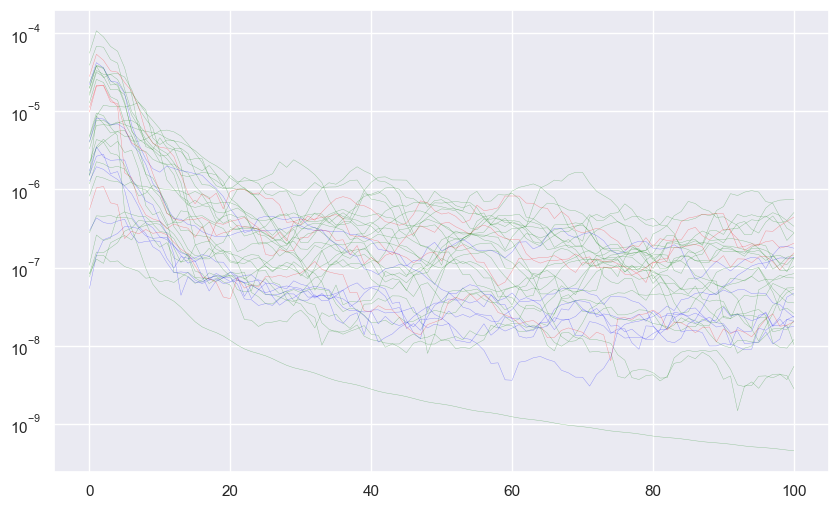

In [11]:
fig = plt.figure(figsize=(10, 6))

for i in range(psds_sub_sniff.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_sniff[i, 0, :], alpha=0.4, linewidth=.3, color='green')

for i in range(psds_sub_follow.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_follow[i, 0, :], alpha=0.4, linewidth=.3, color='blue')

for i in range(psds_sub_groom.shape[0]):
    sns.lineplot(x=freqs, y=psds_sub_groom[i, 0, :], alpha=0.4, linewidth=.3, color='red')

plt.yscale('log')
plt.show()

### Power Spectral Density (PSD) calculation for the one subject

In [15]:
df = pd.DataFrame()

for event_type in epochs.metadata.interaction_kind.unique():

    subject_data = epochs[epochs.metadata["interaction_kind"] == event_type]
    subject_id = subject_data.metadata["subject_id"].iloc[0]
    genotype = subject_data.metadata["genotype"].iloc[0]

    for channel in wanted_chans:
        # skip plotting data of bad quality
        if int(subject_id) in low_qual_chans.keys():
            if channel in low_qual_chans[int(subject_id)]:
                print(f"Omitting channel {channel} for subject {subject_id}.")
                continue

        # get the average PSD for this subject
        psds_sub, freqs = psd_array_multitaper(
            subject_data.get_data(picks=channel),
            fmin=0, fmax=100,
            sfreq=subject_data.info['sfreq'],
            n_jobs=-1,
            verbose='WARNING'
        )
        total_power = np.sum(psds_sub, axis=-1)
        psds_sub_norm = psds_sub / total_power[:, np.newaxis]

        mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
        mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)

        # save the average of this subject, so we can later plot the mean of the subject averages
        df = pd.concat([df, pd.DataFrame({
            "freq": freqs,
            "psd (means)": mean_psd_sub,
            "psd (norm)": mean_psd_sub_norm,
            "subject_id": subject_id,
            "genotype": genotype,
            "channel": channel,
            "event_type": event_type,
        })])

Let's inspect it a bit

In [16]:
df.head()

freq  psd (means)  psd (norm) subject_id genotype channel event_type
0   0.0     0.000011    0.060030      78233  DRD2-WT   OFC_R      sniff
1   1.0     0.000021    0.116532      78233  DRD2-WT   OFC_R      sniff
2   2.0     0.000019    0.108938      78233  DRD2-WT   OFC_R      sniff
3   3.0     0.000015    0.084923      78233  DRD2-WT   OFC_R      sniff
4   4.0     0.000014    0.082407      78233  DRD2-WT   OFC_R      sniff

And now we plot the distinct event powers for all channels. As we're only looking at one subject, we cannot yet compare genotype differences

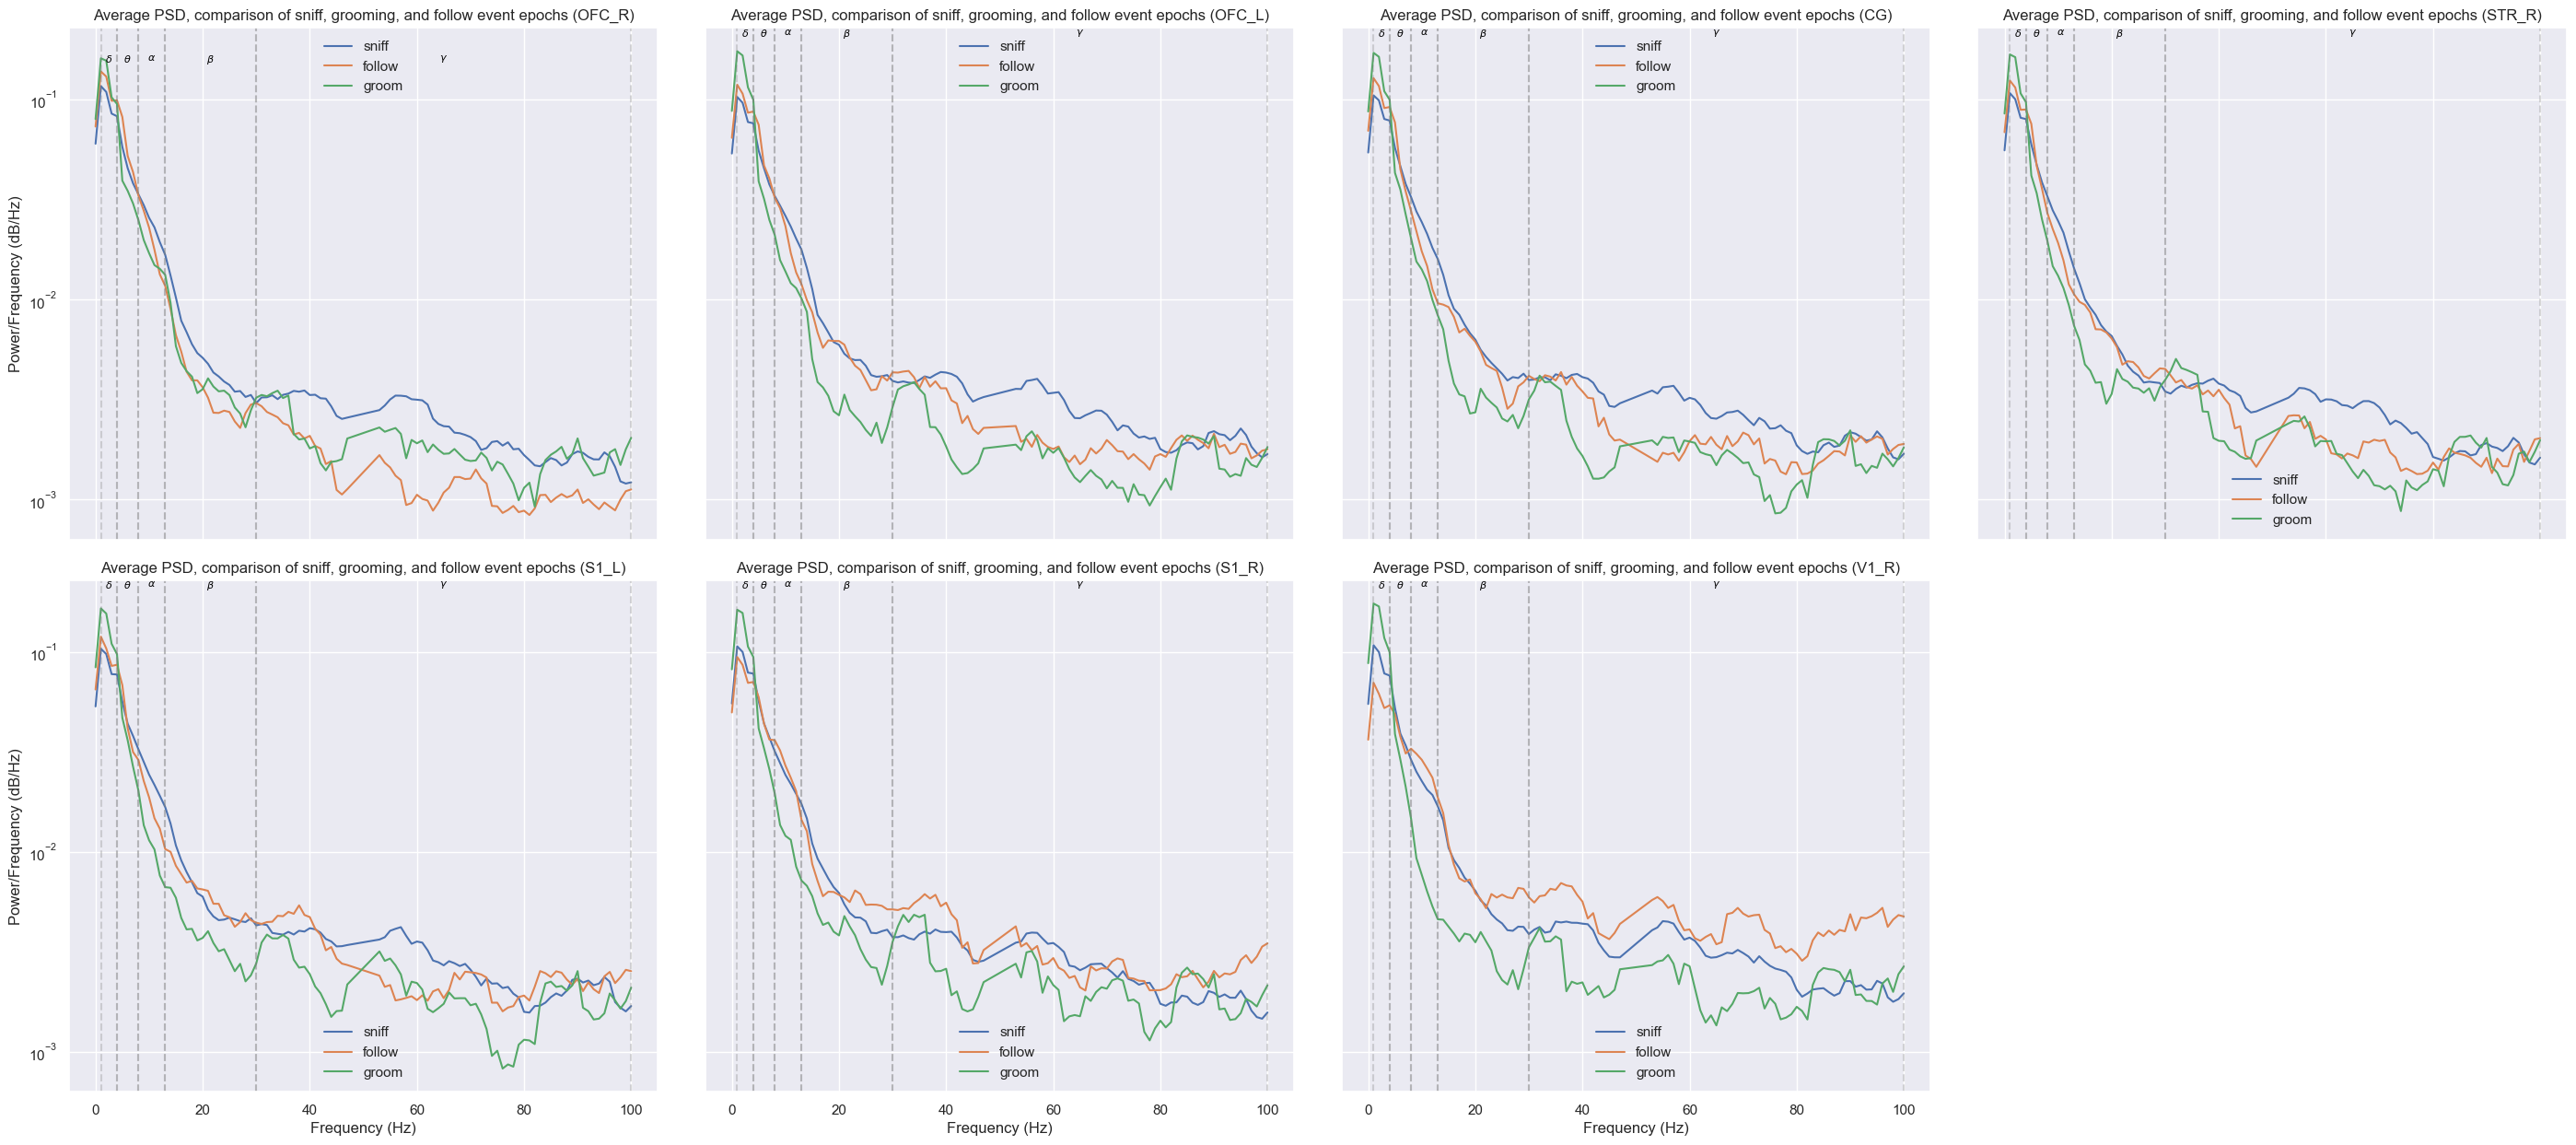

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(35, 15), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 52) | (channel_data.freq < 48)]  # remove the 50Hz peak

    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="event_type", legend=True, ax=axs[i], errorbar=('ci', 95))

    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(f'Average PSD, comparison of sniff, grooming, and follow event epochs ({channel})')
    axs[i].legend(frameon=False, loc='best')

plt.subplots_adjust(wspace=0.08, hspace=0.08)
axs[-1].remove()
plt.show()

## Analysis of all subjects

First we load all the epoch files

In [19]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    if not file.endswith('.fif'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

First, let's calculate how many epochs of each kind of event there are in total

In [20]:
total_epochs = {}

for subject_epochs in all_subject_epochs:
    for event_type in subject_epochs.metadata.interaction_kind.unique():
        if not event_type in total_epochs.keys():
            total_epochs[event_type] = len(subject_epochs[subject_epochs.metadata["interaction_kind"] == event_type])
        else:
            total_epochs[event_type] = total_epochs[event_type] + len(subject_epochs[subject_epochs.metadata["interaction_kind"] == event_type])
total_epochs

{'sniff': 1240, 'follow': 126, 'groom': 65}

Let's calculate the PSDs again, but now for all animals

In [92]:
df = pd.DataFrame()

for subject_epochs in all_subject_epochs:

    subject_id = subject_epochs.metadata["subject_id"].iloc[0]
    genotype = subject_epochs.metadata["genotype"].iloc[0]

    for event_type in subject_epochs.metadata.interaction_kind.unique():

        subject_data = subject_epochs[subject_epochs.metadata["interaction_kind"] == event_type]

        for channel in wanted_chans:
            # skip plotting data of bad quality
            if int(subject_id) in low_qual_chans.keys():
                if channel in low_qual_chans[int(subject_id)]:
                    print(f"Omitting channel {channel} for subject {subject_id}.")
                    continue

            # get the average PSD for this subject
            psds_sub, freqs = psd_array_multitaper(
                subject_data.get_data(picks=channel),
                fmin=0, fmax=100,
                sfreq=subject_data.info['sfreq'],
                n_jobs=-1,
                verbose='WARNING'
            )
            decibels = nanpow2db(psds_sub)

            # normalize the decibels
            total_power = np.abs(np.sum(decibels, axis=-1))
            decibels_norm = decibels / total_power[:, np.newaxis]

            mean_decibels = np.mean(decibels[:, 0, :], axis=0)
            mean_decibels_norm = np.mean(decibels_norm[:, 0, :], axis=0)

            # normalize the raw psds
            total_power = np.sum(psds_sub, axis=-1)
            psds_sub_norm = psds_sub / total_power[:, np.newaxis]

            # average the powers of all epochs
            mean_psd_sub = np.mean(psds_sub[:, 0, :], axis=0)
            mean_psd_sub_norm = np.mean(psds_sub_norm[:, 0, :], axis=0)

            # save the average of this subject, so we can later plot the mean of the subject averages
            df = pd.concat([df, pd.DataFrame({
                "freq": freqs,
                "psd (means)": mean_psd_sub,
                "psd (norm)": mean_psd_sub_norm,
                "decibels": mean_decibels,
                "decibels (norm)": mean_decibels_norm,
                "subject_id": subject_id,
                "genotype": genotype,
                "channel": channel,
                "event_type": event_type,
            })])

    print(f"Done with subject {subject_id}.")

Omitting channel OFC_L for subject 80625.
Omitting channel OFC_L for subject 80625.
Done with subject 80625.
Done with subject 80108.
Done with subject 81175.
Omitting channel OFC_R for subject 39489.
Omitting channel OFC_R for subject 39489.
Done with subject 39489.
Done with subject 79604.
Done with subject 81218.
Done with subject 78233.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Omitting channel OFC_R for subject 81193.
Omitting channel OFC_L for subject 81193.
Done with subject 81193.
Done with subject 78244.
Done with subject 79592.
Done with subject 79593.
Done with subject 78211.
Done with subject 78227.
Done with subject 81217.
Done with subject 81207.
Done with subject 80630.
Done with subject 80620.
Done with subject 39508.
Done with subject 79602.


Let's check if the dataframe contains what we think it does: all subjects, two types of interactions and the genotypes

In [24]:
print(f'Unique subjects: {df.subject_id.unique()} (n={len(df.subject_id.unique())})')
print(f'The genotypes: {[df[df.subject_id == subject_id].genotype.iloc[0] for subject_id in df.subject_id.unique()]}')
print(f'Unique interactions: {df.event_type.unique()}')

Unique subjects: ['80625' '80108' '81175' '39489' '79604' '81218' '78233' '81193' '78244'
 '79592' '79593' '78211' '78227' '81217' '81207' '80630' '80620' '39508'
 '79602'] (n=19)
The genotypes: ['DRD2-KO', 'DRD2-WT', 'DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-WT', 'DRD2-KO', 'DRD2-WT', 'DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-KO', 'DRD2-WT', 'DRD2-WT', 'DRD2-WT', 'DRD2-WT', 'DRD2-WT', 'DRD2-WT']
Unique interactions: ['sniff' 'follow' 'groom']


So there are 10 KOs and 9 WTs

First, let's make an overview grid plot of each subjects PSDs per channel

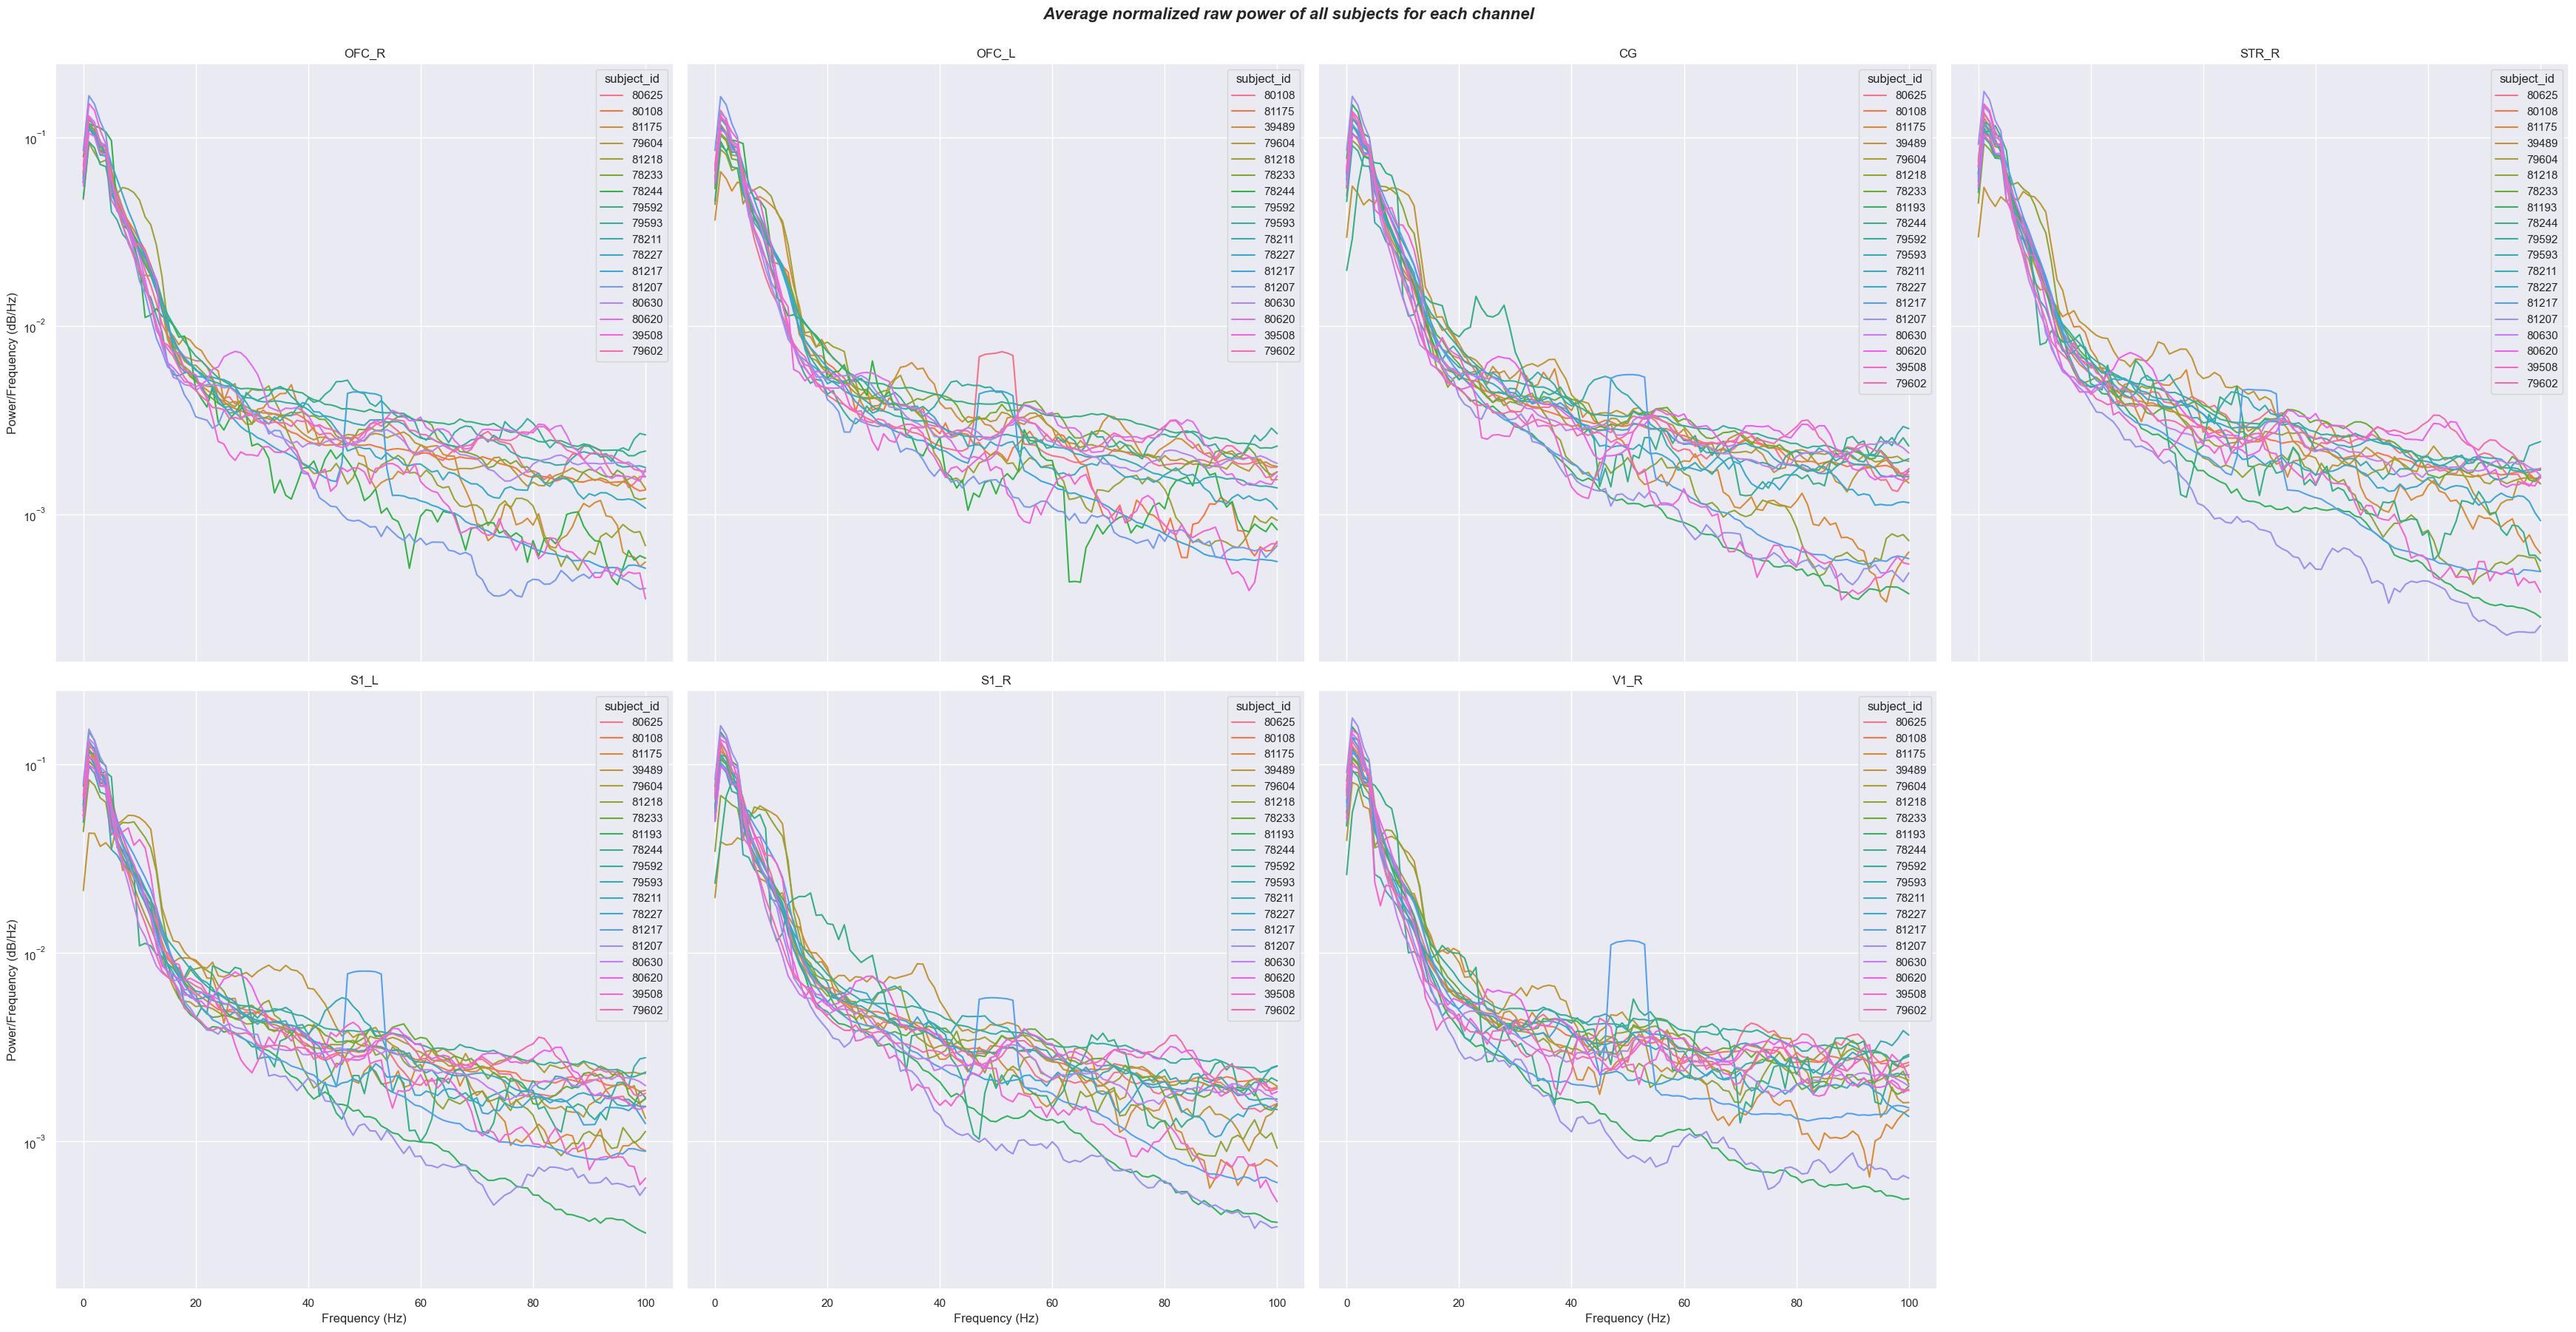

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]

    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average normalized raw power of all subjects for each channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
plt.show()

In [94]:
df = df[~df.subject_id.isin(['81217', '39489', '81193', '81207'])]
df.subject_id.unique()

array(['80625', '80108', '81175', '79604', '81218', '78233', '78244',
       '79592', '79593', '78211', '78227', '80630', '80620', '39508',
       '79602'], dtype=object)

Now that low quality subjects are removed, plot again

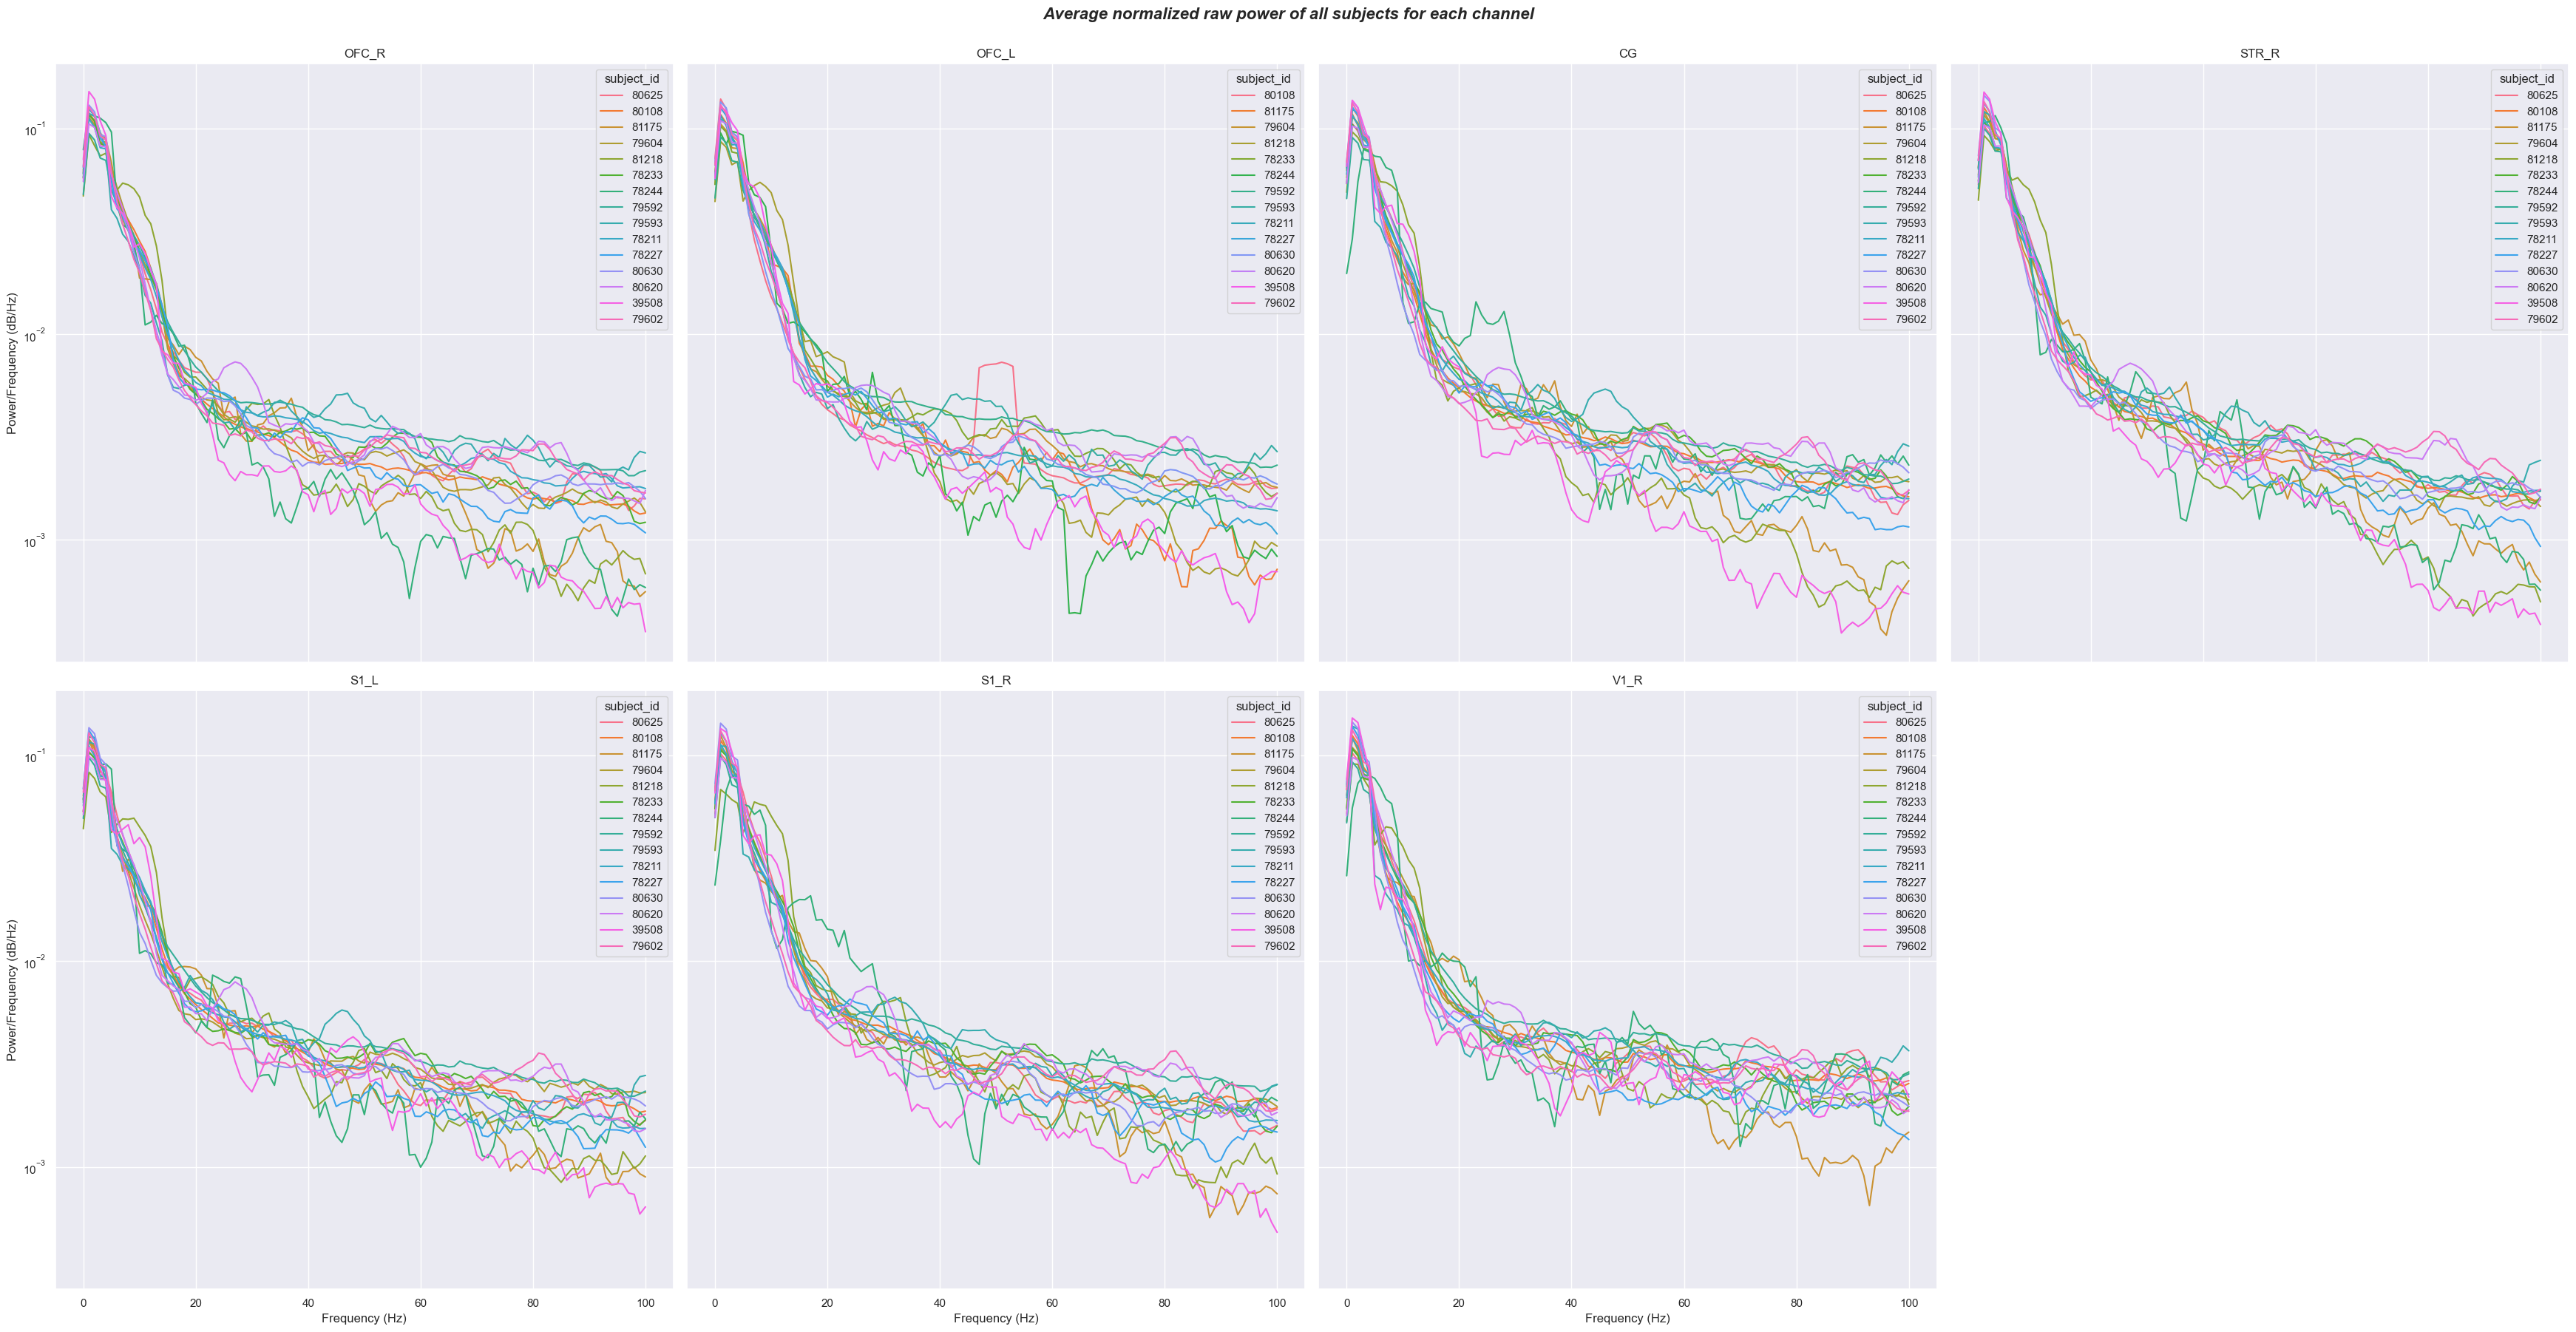

In [95]:
fig, axs = plt.subplots(2, 4, figsize=(35, 18), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[(df.channel == channel) & (df.event_type == "sniff")]

    sns.lineplot(channel_data, y='psd (norm)', x='freq', hue='subject_id', ax=axs[i], errorbar=None)

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average normalized raw power of all subjects for each channel',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
plt.show()

Let's batch all distinct types of epochs (sniff, groom follow) and show the average powers

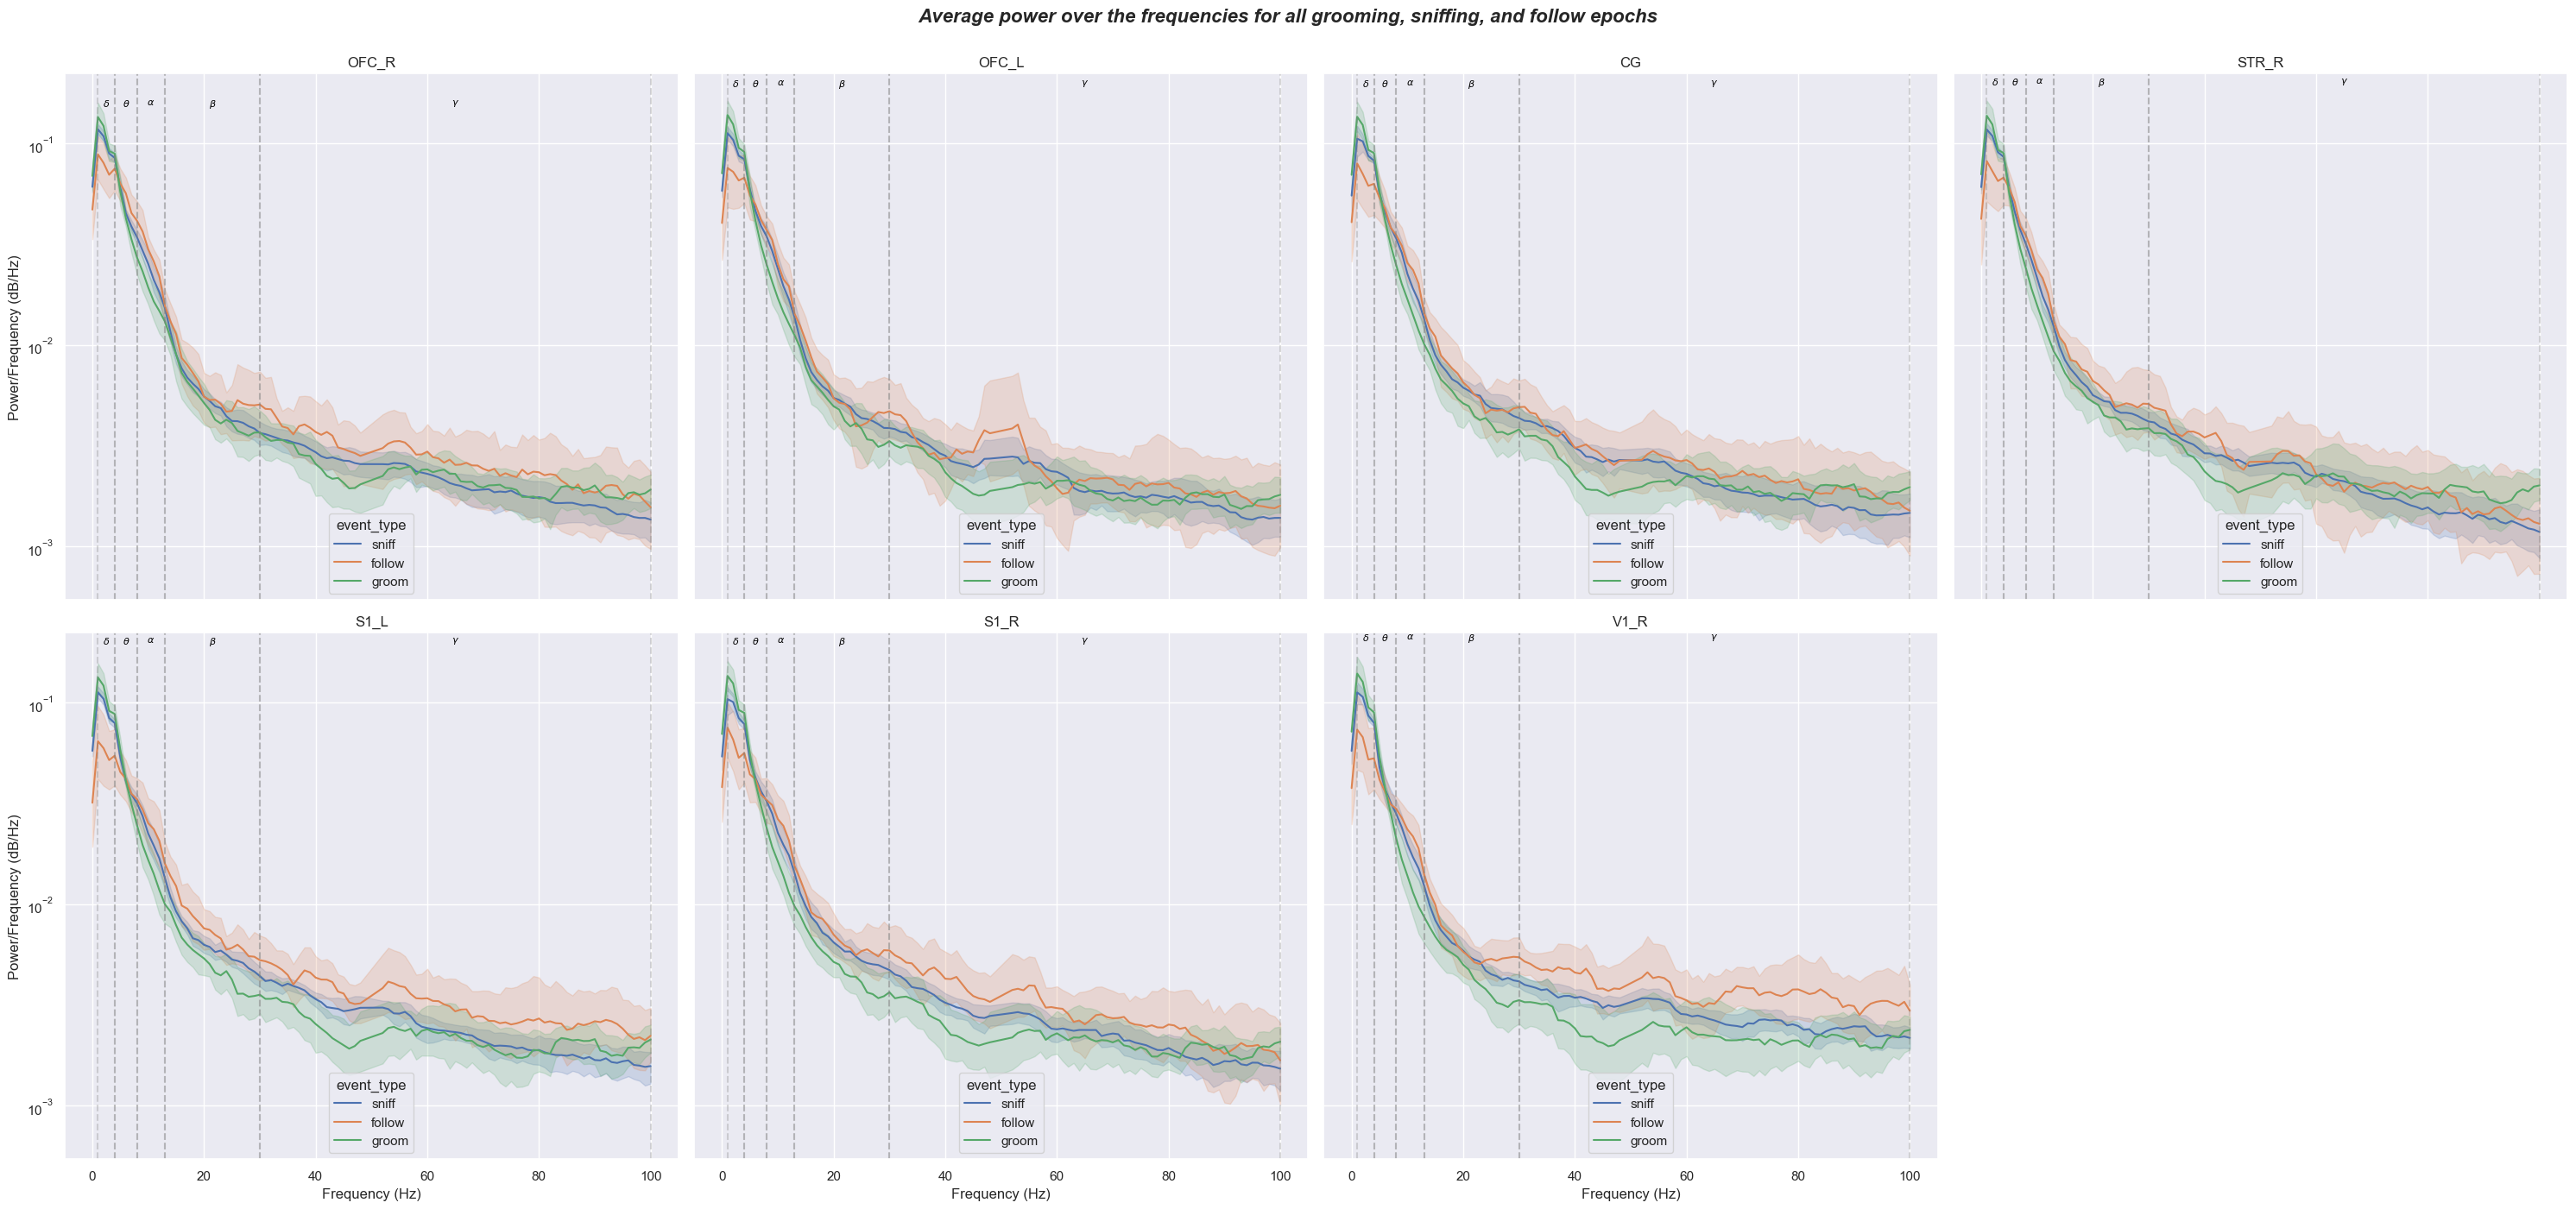

In [96]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak

    sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="event_type", legend=True, ax=axs[i], errorbar=('ci', 95))

    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

    axs[i].set_yscale('log')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Power/Frequency (dB/Hz)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average power over the frequencies for all grooming, sniffing, and follow epochs',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
plt.show()

Let's also do this for the to decibel transformed PSD values

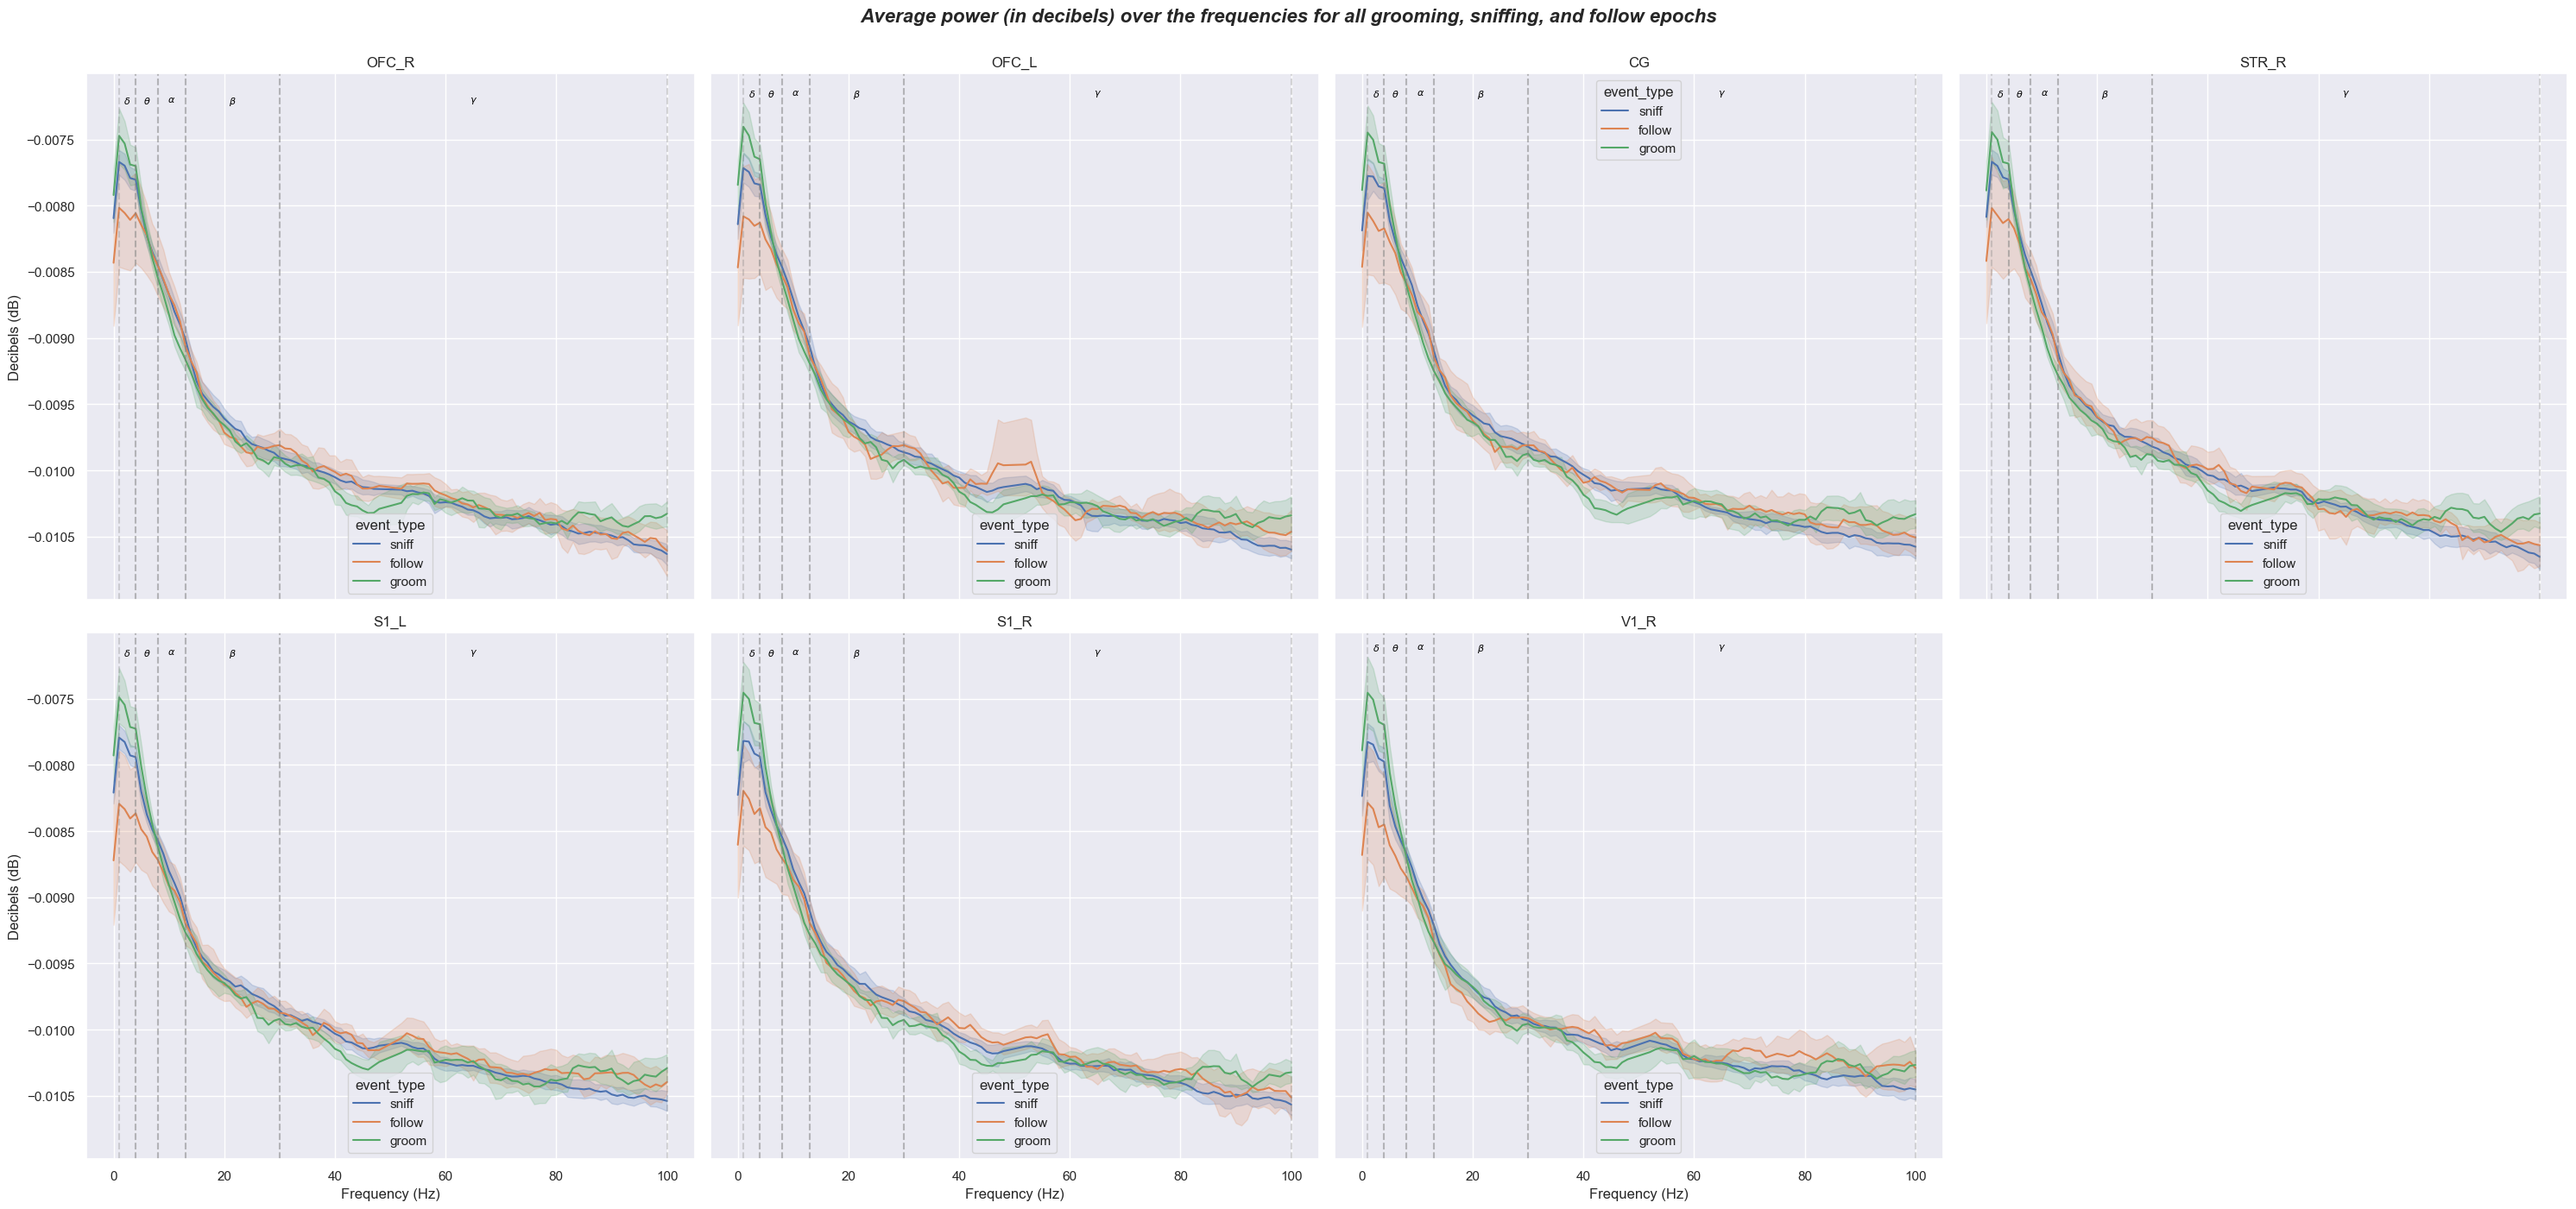

In [97]:
fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
axs = axs.ravel()

for i, channel in enumerate(wanted_chans):

    channel_data = df[df.channel == channel]
    channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak

    sns.lineplot(data=channel_data, x='freq', y='decibels (norm)', hue="event_type", legend=True, ax=axs[i], errorbar=('ci', 95))

    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Decibels (dB)')
    axs[i].set_title(channel)

plt.suptitle(
    'Average power (in decibels) over the frequencies for all grooming, sniffing, and follow epochs',
    fontsize=16, fontweight='bold', fontstyle='italic', y=1
)
plt.tight_layout()
axs[-1].remove()
plt.show()

### Are there power differences between the genotypes during the distinct events?

Now plot the normalized PSDs per event type and hue also on genotype

In [99]:
for event_type in df.event_type.unique():

    fig, axs = plt.subplots(2, 4, figsize=(30, 14), sharex=True, sharey=True)
    axs = axs.ravel()

    event_data = df[df.event_type == event_type]
    
    # get the subject's averages for every frequency of each channel 
    subject_averages = event_data.groupby(['subject_id', 'channel', 'freq']).agg({
        'psd (means)': 'mean', 
        'psd (norm)': 'mean',
        'genotype': 'first'
    }).reset_index()

    for i, channel in enumerate(wanted_chans):

        channel_data = subject_averages[subject_averages.channel == channel]
        channel_data = channel_data[(channel_data.freq > 51) | (channel_data.freq < 49)]  # remove the 50Hz peak

        sns.lineplot(data=channel_data, x='freq', y='psd (norm)', hue="genotype", legend=True, ax=axs[i], errorbar=('ci', 95), palette=palette_gr)

        for band, (start, end) in freq_bands_eeg.items():
            axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        
        axs[i].legend(frameon=False)
        axs[i].set_yscale('log')
        axs[i].set_xlabel('Frequency (Hz)')
        axs[i].set_ylabel('Power/Frequency')
        axs[i].set_title(channel)

    plt.suptitle(f'Average normalized power during {event_type} events DRD2-WT vs DRD2-KO ({total_epochs[event_type]} epochs)', fontsize=16, fontweight='bold', fontstyle='italic', y=1)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f'power_analysis/average_norm_powers_{event_type}_wo_artifacts.pdf'))